In [380]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as optm

### (a) 데이터 수집 & 월별 평균수익률 & 초과수익률 계산

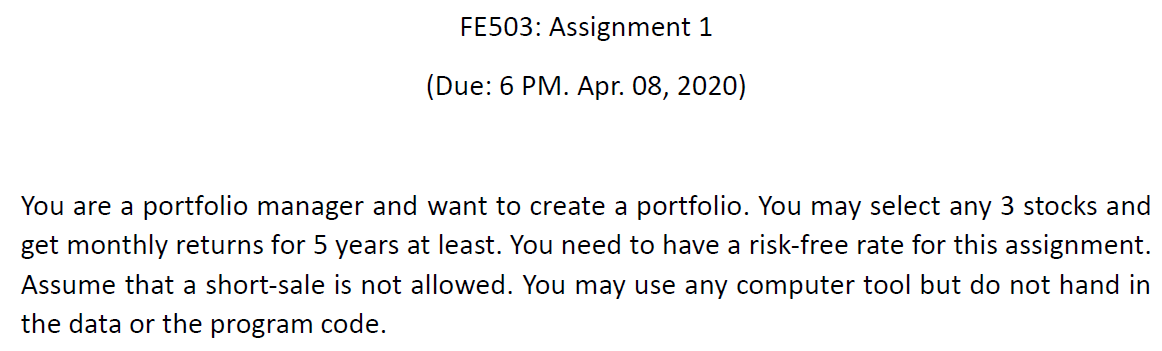

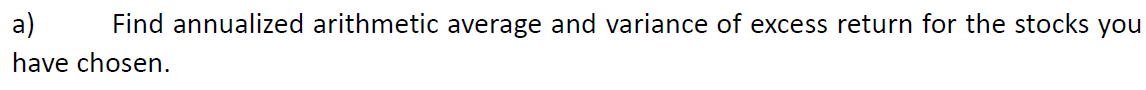

In [325]:
Celltrion = fdr.DataReader('068270', '2014-12', '2020')['Close']
Samsung = fdr.DataReader('005930', '2014-12', '2020')['Close']
NCsoft = fdr.DataReader('036570', '2014-12', '2020')['Close']

Stocks = pd.concat([Celltrion, Samsung, NCsoft], axis=1)
Stocks.columns = ['Celltrion', 'Samsung', 'NCsoft']
m_mean = Stocks.resample('BM').last().pct_change().dropna()

# a - (1) 답
annual_arithmeric_mean = m_mean.mean() * 12

In [326]:
risk_free_y = 0.01
risk_free_m = risk_free_y / 12
excess_return = m_mean - risk_free_m

# a - (2) 답
annual_var = excess_return.var() * 12

### (b) Variance-Covariance Matrix 구하기

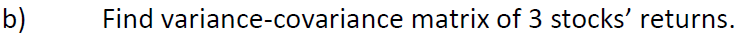

In [327]:
### 쉽게 구하기
cov_mat = m_mean.cov() * 12

In [328]:
### 다른 버전으로 구하기
#상관계수 matirx 구하기
corr = m_mean.corr()
corr_mat = np.array(corr)

#표준편차 matrix 구하기
annual_sd = excess_return.std() * np.sqrt(12)

sd_mat = np.zeros((3,3))
sd_mat[0][0] = annual_sd[0]
sd_mat[1][1] = annual_sd[1]
sd_mat[2][2] = annual_sd[2]

cov_mat_2 = sd_mat.dot(corr_mat).dot(sd_mat)

### (c) Draw Efficient Frontier

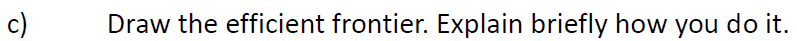

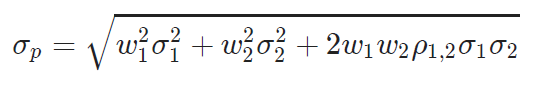

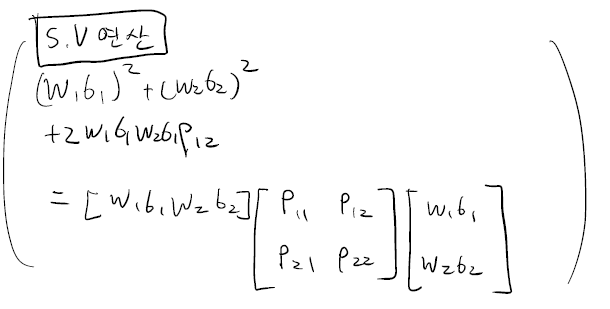

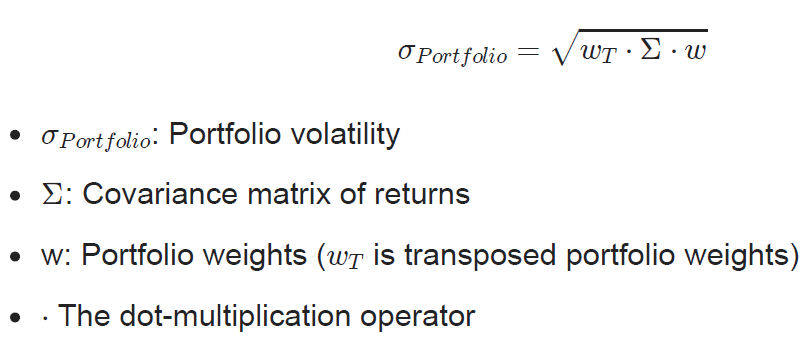

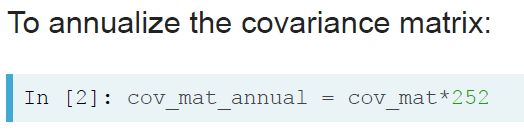

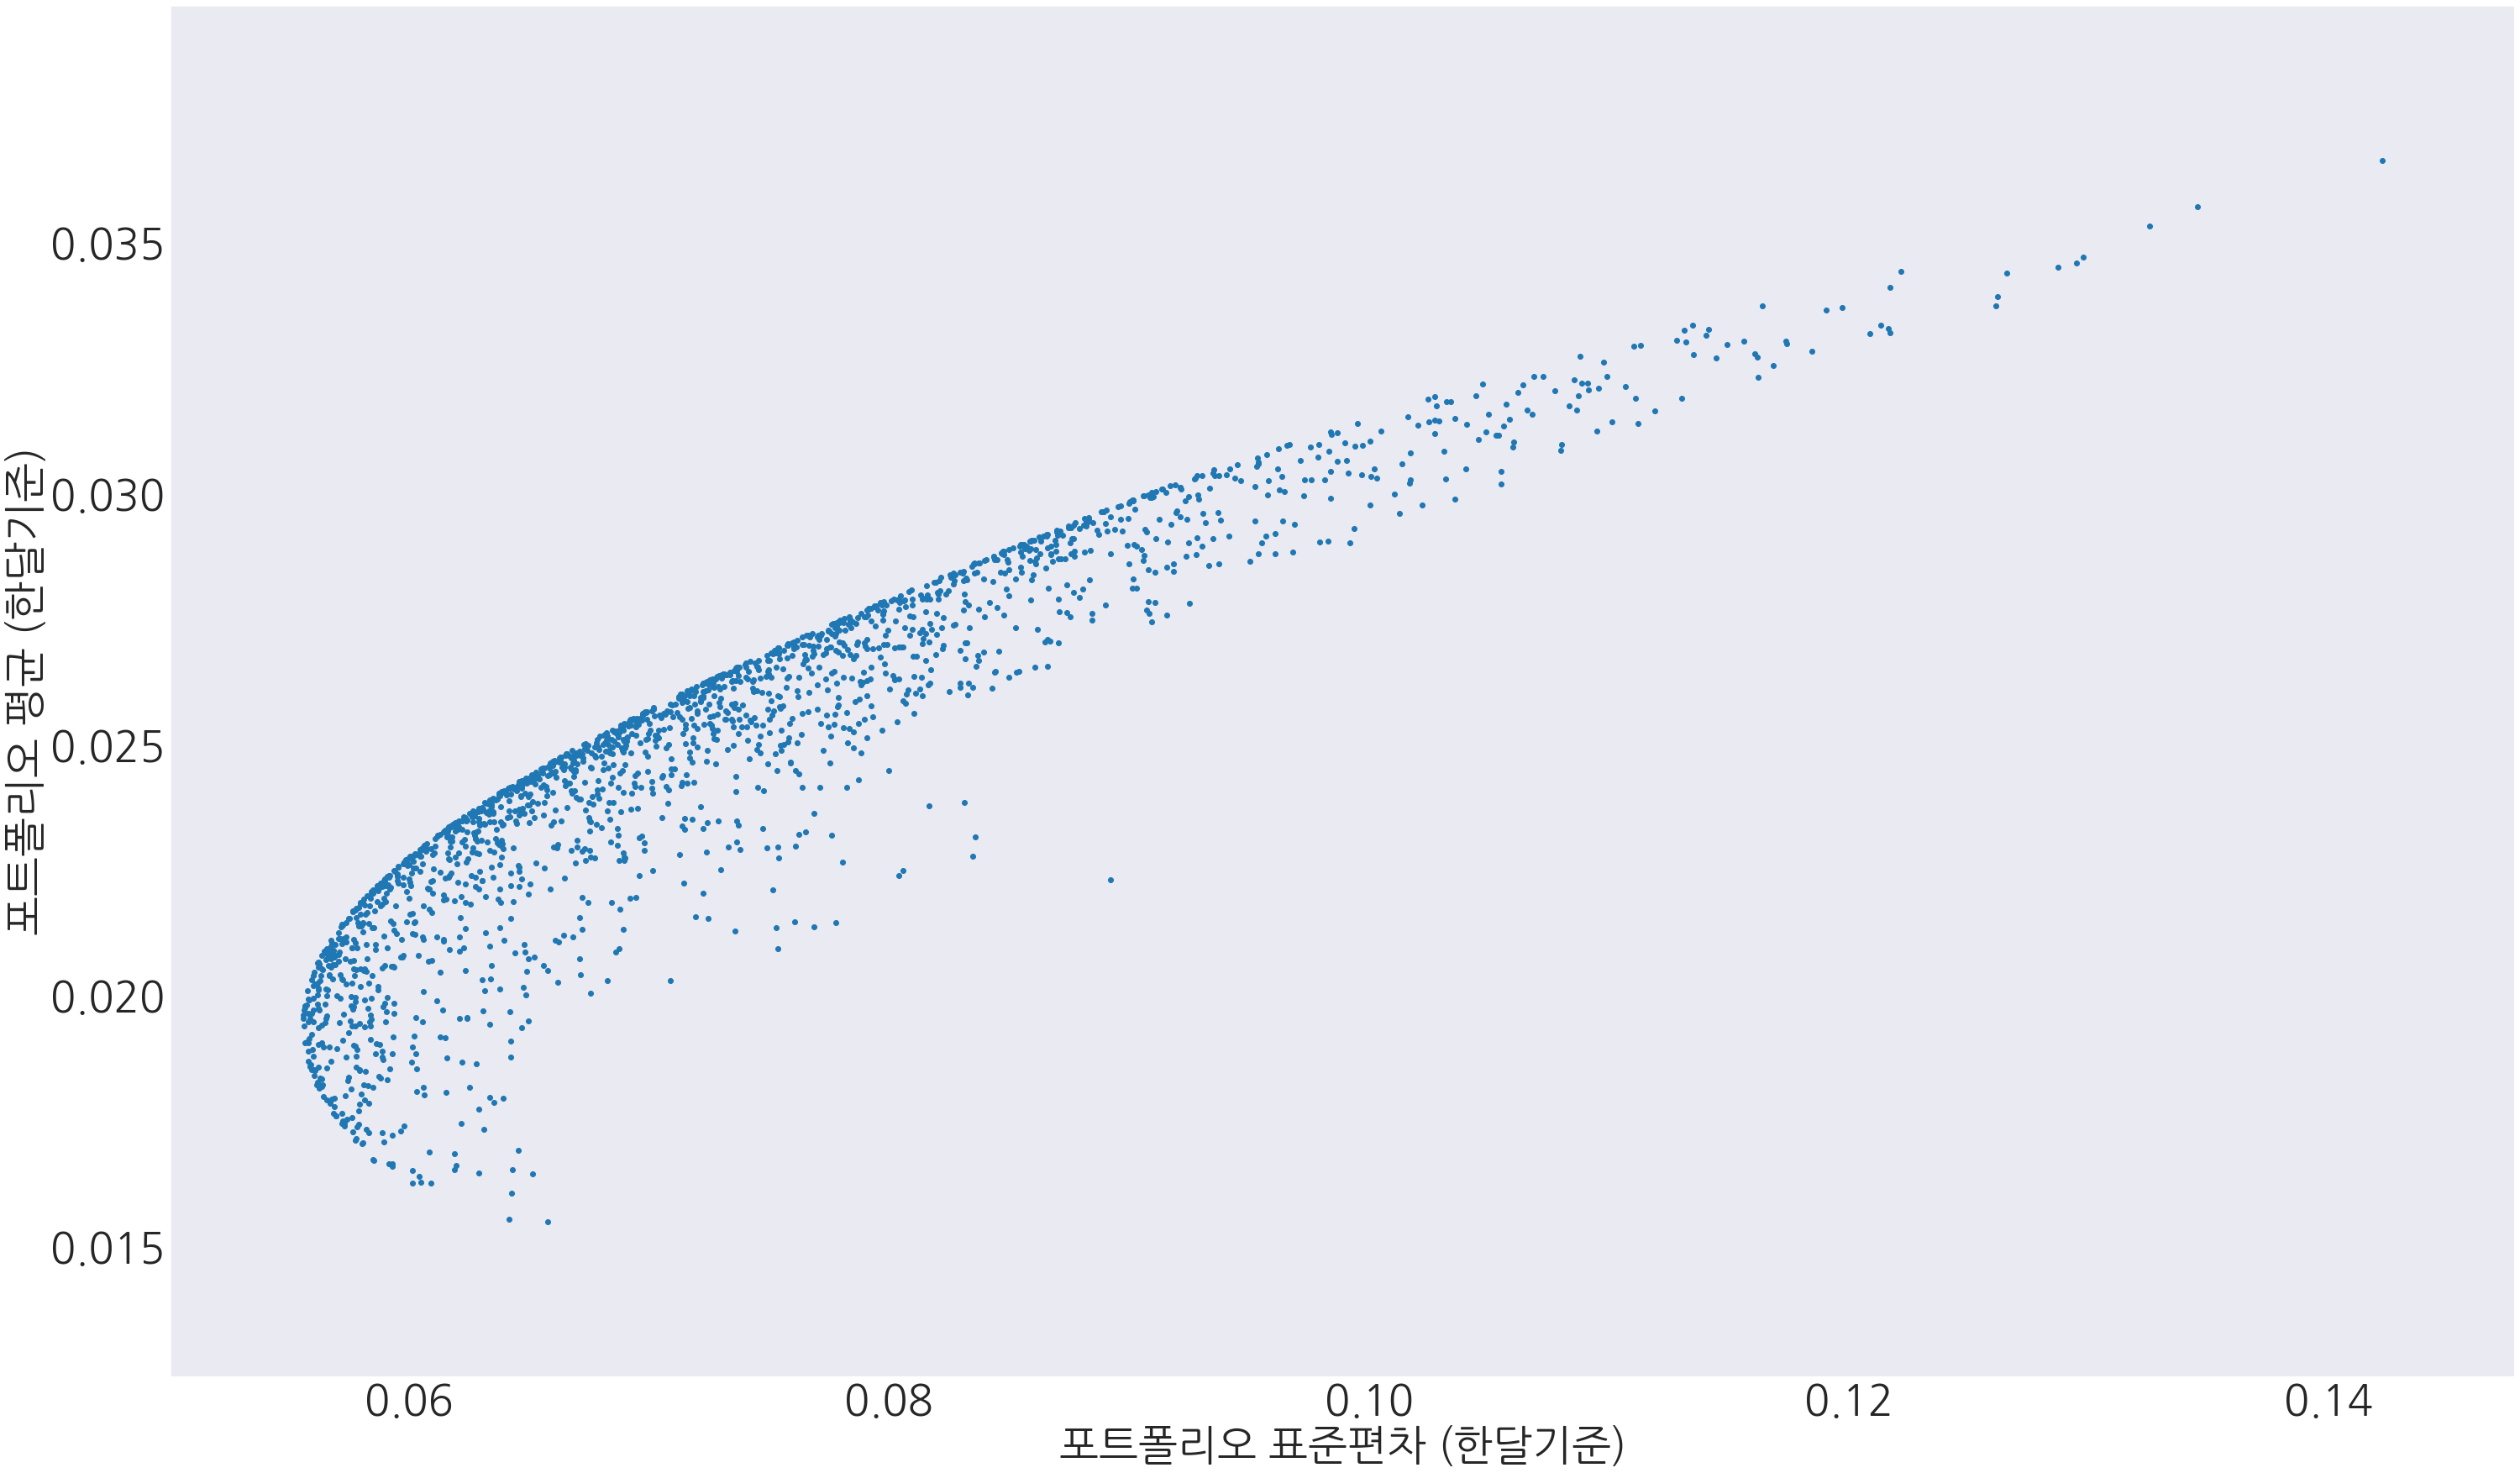

In [588]:
try_num = 2000
stock_num = 3
random_weight = np.random.rand(try_num,stock_num)
stock_name_list = Stocks.columns.tolist()

weight = pd.DataFrame()

for name, num in zip(stock_name_list, list(range(stock_num))) :
    weight[name] = pd.Series(random_weight[:, num] / random_weight.sum(axis=1))

monthly_mean =  m_mean.mean()
monthly_cov_mat =  cov_mat / 12

def portfolio_mean(x):
    return( sum ( np.array ( monthly_mean ) * np.array (x) ))

def portfolio_sd(x):
    return(np.dot ( np.dot ( np.array(x).T, monthly_cov_mat), np.array(x)) ** 0.5)

port_ret = weight.apply(portfolio_mean, axis=1)
port_sd = weight.apply(portfolio_sd, axis=1)

port = pd.concat([port_ret, port_sd], axis=1)
port.columns = ['port_ret', 'port_sd']

sns.set_style('dark')

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 50

plt.figure(figsize = (50,30))
plt.xlabel('포트폴리오 표준편차 (한달기준)')
plt.ylabel('포트폴리오 평균 (한달기준)')
plt.scatter(port_sd, port_ret)

### (d) Find Tangent portfoilo & CAL

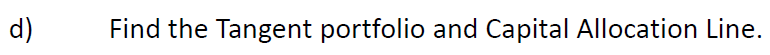

optimized_w : ['0.24016', '0.38705', '0.37278']
tangent_sharp : 0.36525
tangent_mean : 0.02301
tangent_sd : 0.06073


C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


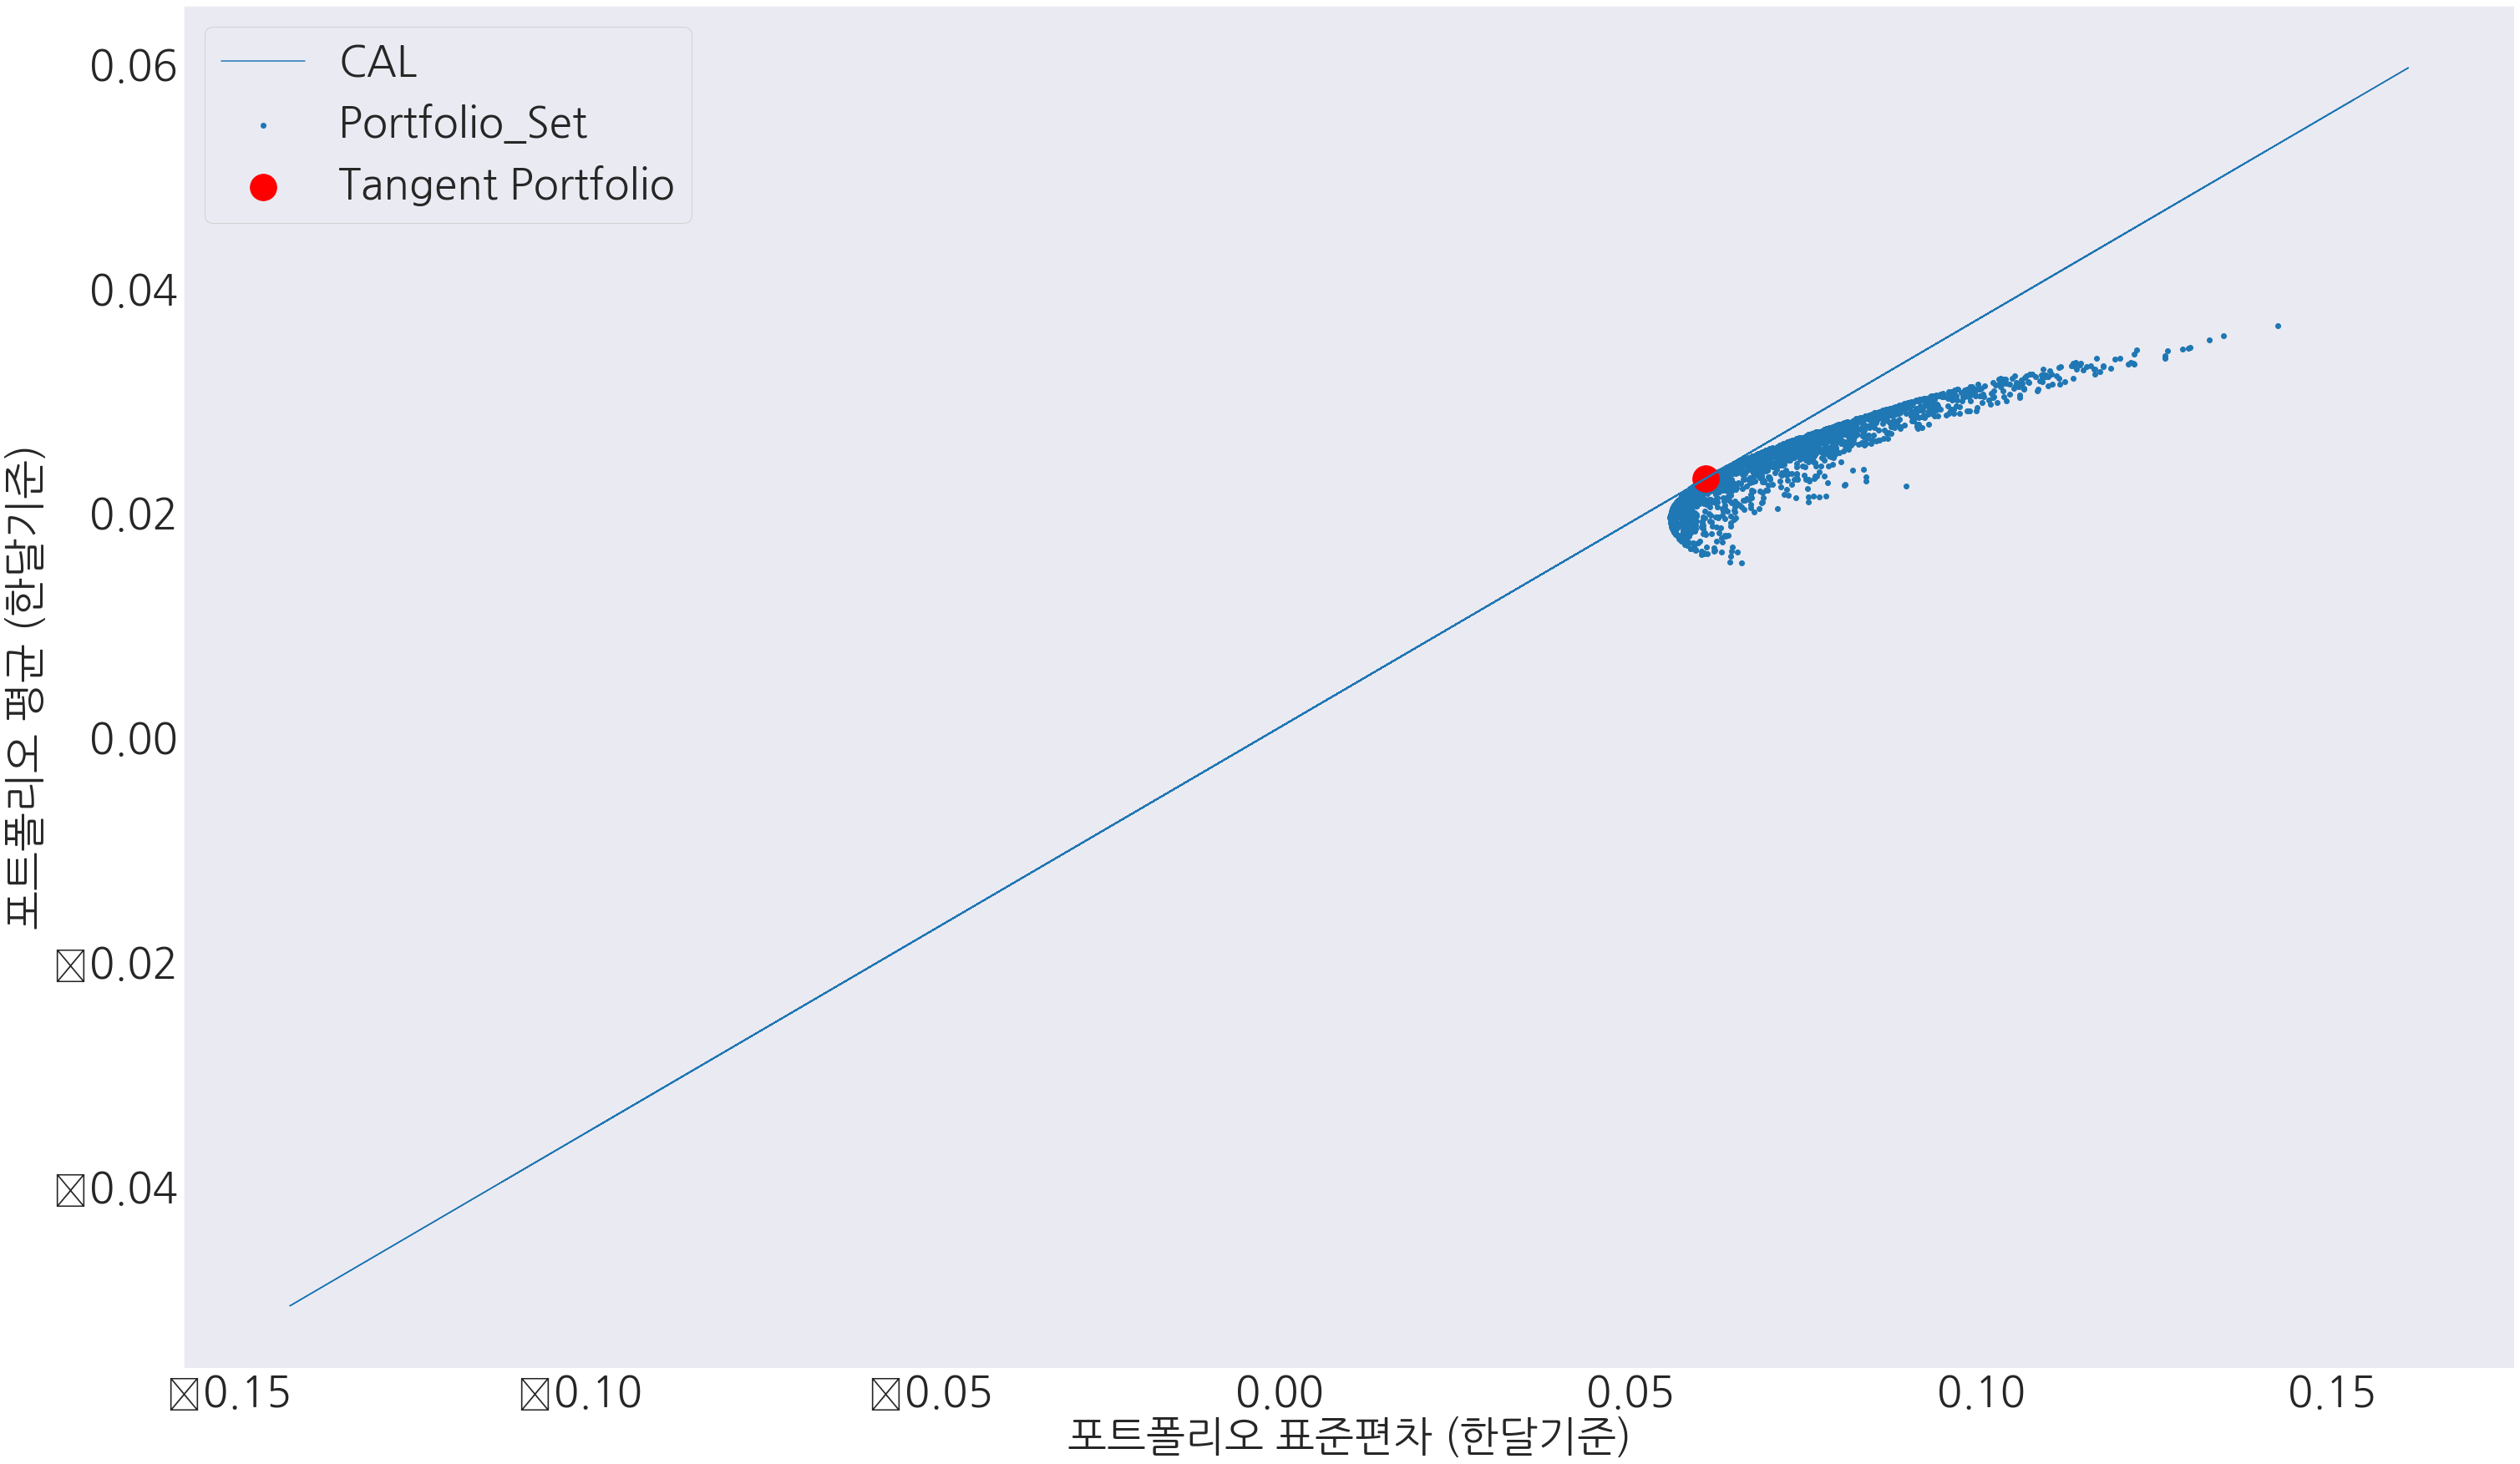

In [590]:
#초깃값 설정
x0 = [0.3, 0.3, 0.4]
risk_free_m = 0.01 / 12
cons = [{'type':'eq', 'fun': lambda x: sum(x) - 1 }]

def objective(x):
    return - ( portfolio_mean(x) - risk_free_m ) / portfolio_sd(x)

tangent_portfolio = optm.minimize(objective, x0, method = 'SLSQP', constraints = cons)

tangent_mean = portfolio_mean(tangent_portfolio.x)
tangent_sd = portfolio_sd(tangent_portfolio.x)

slope = (tangent_mean - risk_free_m ) / tangent_sd
x = np.random.normal(tangent_mean, tangent_sd, 100)
y = slope * x + risk_free_m

sns.set_style('dark')

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 50

plt.figure(figsize = (50,30))
plt.xlabel('포트폴리오 표준편차 (한달기준)')
plt.ylabel('포트폴리오 평균 (한달기준)')
plt.scatter(port_sd, port_ret)
plt.plot(x,y)
plt.scatter(tangent_sd, tangent_mean, s = 1000, c = 'r')
plt.legend(['CAL', 'Portfolio_Set', 'Tangent Portfolio'])

In [591]:
tangent_sharp = (tangent_mean - risk_free_m ) / tangent_sd
optimized_w = str( pd.Series(tangent_portfolio.x).map(lambda x : str(x)[:7]).tolist() )

print('optimized_w : ' + optimized_w)
print('tangent_sharp : ' + str(tangent_sharp)[:7])
print('tangent_mean : ' + str(tangent_mean)[:7])
print('tangent_sd : ' + str(tangent_sd)[:7])

optimized_w : ['0.24016', '0.38705', '0.37278']
tangent_sharp : 0.36525
tangent_mean : 0.02301
tangent_sd : 0.06073


### (e) 20% 보유 제약 있을 때 Efiicnet Frontier & 통계치 변화

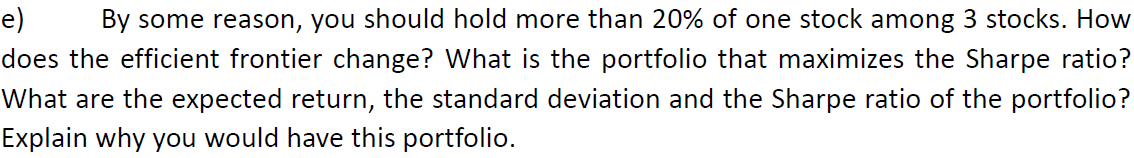

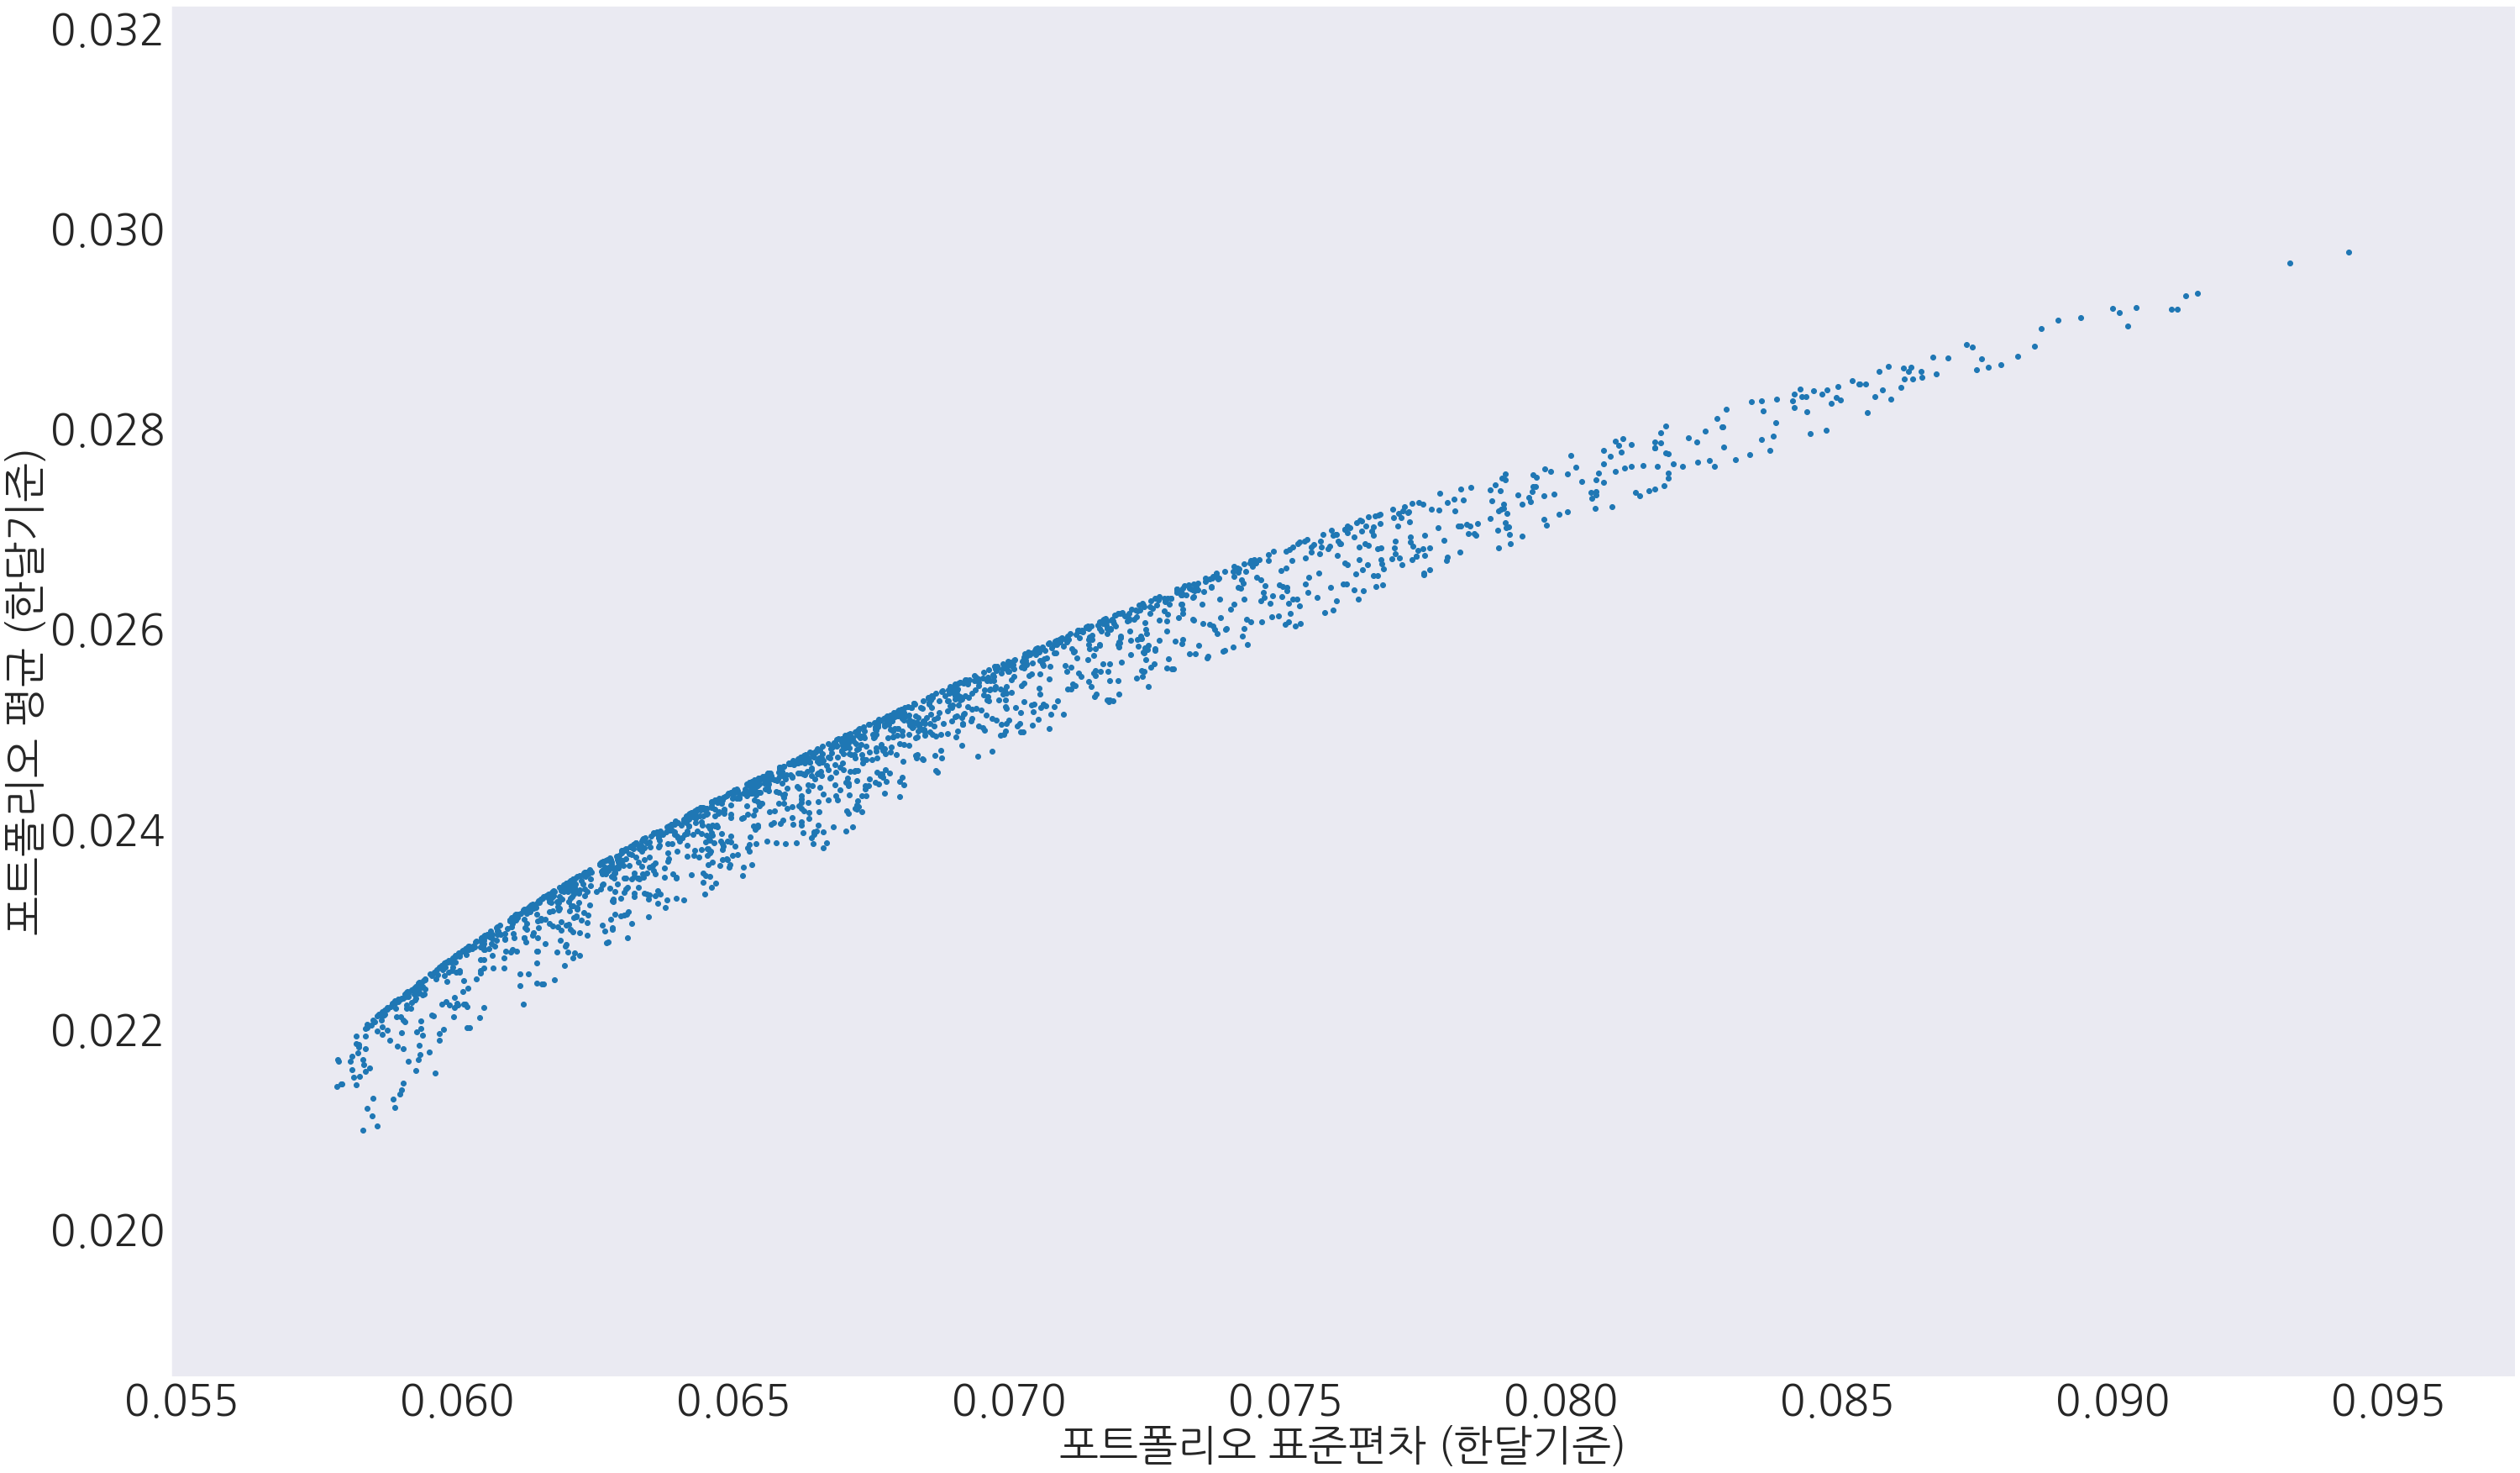

In [592]:
try_num = 6000
stock_num = 3
random_weight = np.random.rand(try_num,stock_num)
stock_name_list = Stocks.columns.tolist()

weight = pd.DataFrame()

for name, num in zip(stock_name_list, list(range(stock_num))) :
    weight[name] = pd.Series(random_weight[:, num] / random_weight.sum(axis=1))
    
# 20% 이상의 weight 제약
weight = weight.applymap(lambda x  : x if x > 0.2 else np.nan ).dropna()

monthly_mean =  m_mean.mean()
monthly_cov_mat =  cov_mat / 12

def portfolio_mean(x):
    return( sum ( np.array ( monthly_mean ) * np.array (x) ))

def portfolio_sd(x):
    return(np.dot ( np.dot ( np.array(x).T, monthly_cov_mat), np.array(x)) ** 0.5)

port_ret = weight.apply(portfolio_mean, axis=1)
port_sd = weight.apply(portfolio_sd, axis=1)

port = pd.concat([port_ret, port_sd], axis=1)
port.columns = ['port_ret', 'port_sd']

sns.set_style('dark')

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 50

plt.figure(figsize = (50,30))
plt.xlabel('포트폴리오 표준편차 (한달기준)')
plt.ylabel('포트폴리오 평균 (한달기준)')
plt.scatter(port_sd, port_ret)

C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


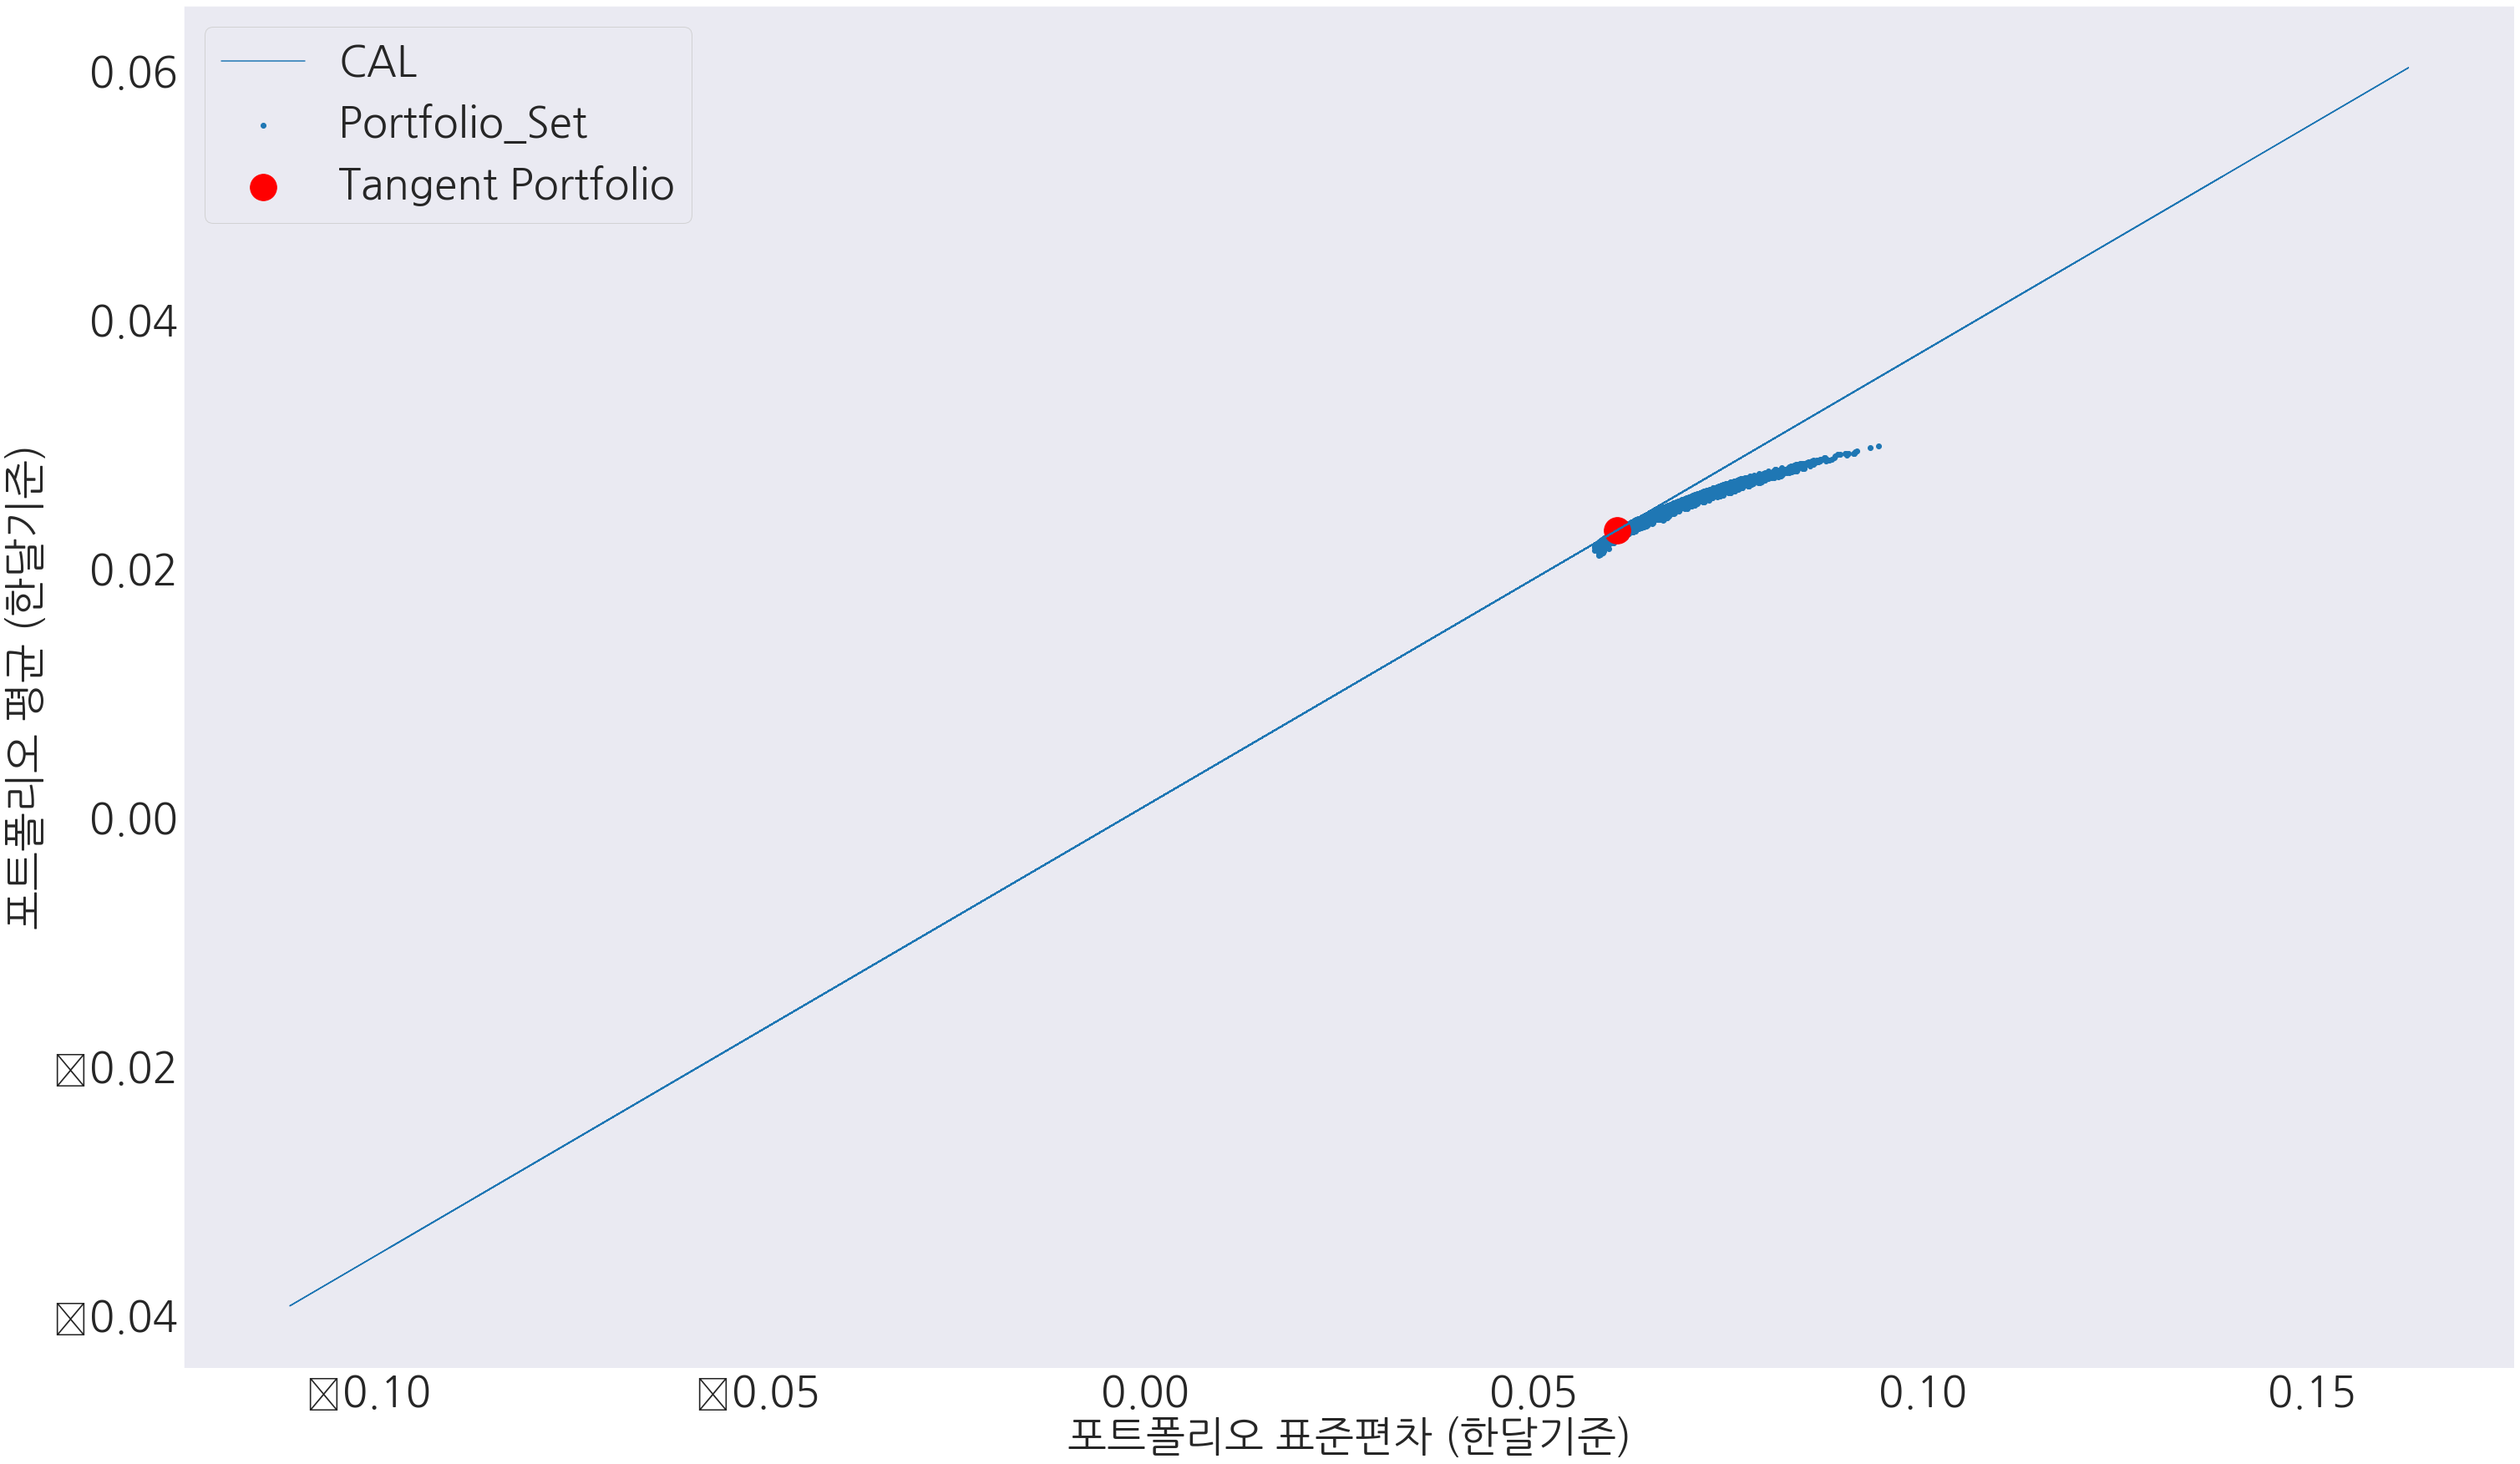

In [608]:
#초깃값 설정
x0 = [0.3, 0.3, 0.4]
risk_free_m = 0.01 / 12
cons = [{'type':'eq', 'fun': lambda x: sum(x) - 1 }]
bnds = tuple([(0.2, 1)] * stock_num)

def objective(weight):
    return - ( portfolio_mean(weight) - risk_free_m ) / portfolio_sd(weight)

tangent_portfolio = optm.minimize(objective, x0, method = 'SLSQP', bounds = bnds, constraints = cons)

tangent_mean = portfolio_mean(tangent_portfolio.x)
tangent_sd = portfolio_sd(tangent_portfolio.x)

slope = (tangent_mean - risk_free_m ) / tangent_sd
x = np.random.normal(tangent_mean, tangent_sd, 100)
y = slope * x + risk_free_m

sns.set_style('dark')

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 50

plt.figure(figsize = (50,30))
plt.xlabel('포트폴리오 표준편차 (한달기준)')
plt.ylabel('포트폴리오 평균 (한달기준)')
plt.scatter(port_sd, port_ret)
plt.plot(x,y)
plt.scatter(tangent_sd, tangent_mean, s = 1000, c = 'r')
plt.legend(['CAL', 'Portfolio_Set', 'Tangent Portfolio'])

In [609]:
tangent_sharp = (tangent_mean - risk_free_m ) / tangent_sd
optimized_w = str( pd.Series(tangent_portfolio.x).map(lambda x : str(x)[:7]).tolist() )

print('optimized_w : ' + optimized_w)
print('tangent_sharp : ' + str(tangent_sharp)[:7])
print('tangent_mean : ' + str(tangent_mean)[:7])
print('tangent_sd : ' + str(tangent_sd)[:7])

optimized_w : ['0.24016', '0.38705', '0.37278']
tangent_sharp : 0.36525
tangent_mean : 0.02301
tangent_sd : 0.06073


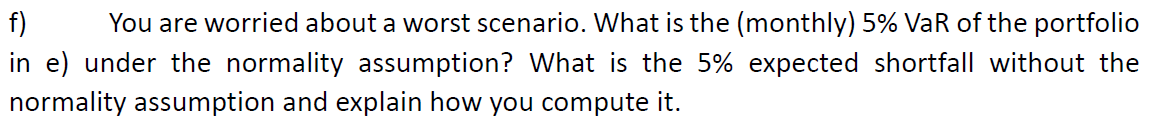

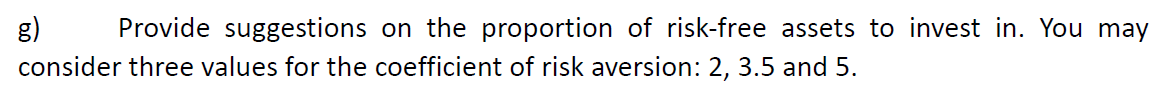

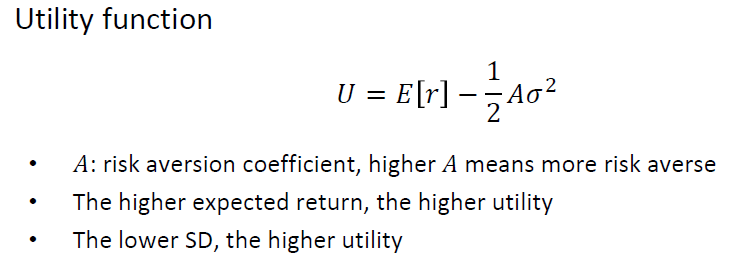

### (g) utility function을 최적화 시키는 w 구하기 ( utility funciton 미분한 값을 0으로 두면 됨 )

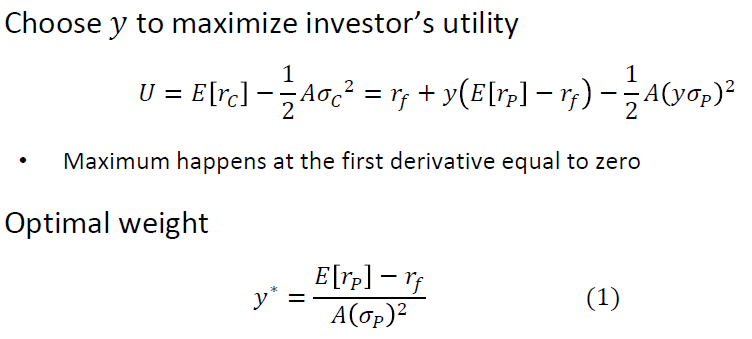

In [611]:
risk_aversion_1 = 2
risk_aversion_2 = 3.5
risk_aversion_3 = 5

y1 = (tangent_mean - risk_free_m)/(risk_aversion_1*(tangent_sd**2))
y2 = (tangent_mean - risk_free_m)/(risk_aversion_2*(tangent_sd**2))
y3 = (tangent_mean - risk_free_m)/(risk_aversion_3*(tangent_sd**2))

In [616]:
print('y1 : ' + str(y1)[:7])
print('y2 : ' + str(y2)[:7])
print('y3 : ' + str(y3)[:7])

y1 : 3.00719
y2 : 1.71839
y3 : 1.20287
